In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter
import matplotlib as mpl


import cv2

# Read data

In [2]:
#Record_2022-09-27_14-14-14.bin
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"
try:
    #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
    #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
    with open(munkholm, "rb") as f:

        data = f.read()
    
        
        
except IOError as e:
    print(e)

In [3]:
stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

292916792
291867276
290817764
289768228
288718768
287669332
286619884
285570448
284520964
283471416
282421840
281372252
280322640
279273168
278223768
277174416
276125028
275075580
274026084
272976492
271926948
270877320
269827672
268778140
267728536
266678908
265629280
264579508
263529896
262480044
261430240
260380304
259330176
258280084
257229848
256179840
255129800
254079820
253029840
251979804
250929680
249879684
248829712
247779672
246729452
245679384
244629344
243579284
242529604
241479868
240430272
239380556
238330728
237281092
236231384
235181344
234131472
233081660
232031428
230981088
229931288
228881656
227831984
226782444
225732800
224683036
223633164
222583292
221533564
220483716
219433932
218384188
217334524
216284904
215235020
214185172
213135236
212085196
211035120
209985288
208935328
207885580
206835580
205785804
204735940
203685992
202636068
201586180
200536376
199486476
198436636
197386640
196336440
195286504
194236520
193186416
192136400
191085892
190035920
188985828


# Background update algorithem

In [4]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [5]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [6]:
frame = data_arr[-1]
length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
data_RADC = frame[8:8+length]
data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
data_RADC = data_RADC.reshape(3,256,512)
data_RADC_I_raw = data_RADC[:,:,::2]
data_RADC_Q_raw = data_RADC[:,:,1::2]


NameError: name 'data_RADC_I_raw' is not defined

<Figure size 10000x3000 with 0 Axes>

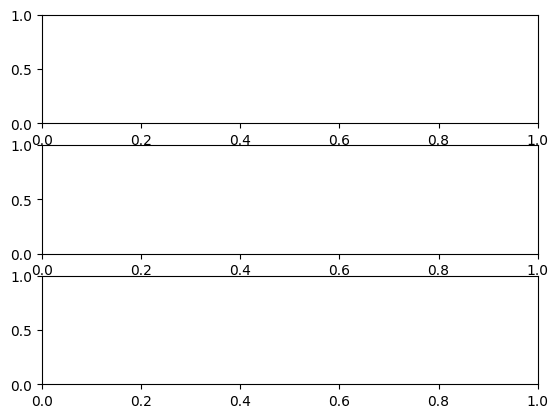

In [10]:
plt.figure(figsize=(100,30))
fig, axs = plt.subplots(3, 1)
axs[0].plot(data_RADC_I_raw[0,100,:],label = "RX1: I-channel")
axs[0].plot(data_RADC_Q_raw[0,100,:],label = "RX1: Q-channel")
axs[0].legend()
axs[0].set_ylabel("Amplitude")

axs[1].plot(data_RADC_I_raw[1,100,:],label = "RX2: I-channel")
axs[1].plot(data_RADC_Q_raw[1,100,:],label = "RX2: Q-channel")
axs[1].legend()
axs[1].set_ylabel("Amplitude")

axs[2].plot(data_RADC_I_raw[2,100,:],label = "RX3: I-channel")
axs[2].plot(data_RADC_Q_raw[2,100,:],label = "RX3: Q-channel")
axs[2].legend()
axs[2].set_ylabel("Amplitude")
plt.xlabel("ADC sample number")
fig.suptitle('Raw ADC data',weight="bold")
fig.tight_layout()

#plt.savefig("plots/raw_adc.svg",format="svg")



plt.show()

In [6]:
def background_update(frames, alpha=1/128, nr_of_ma=1,window=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        #window = signal.windows.chebwin(256, 100, sym=True)#signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
       #data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM.copy()
    raw_frames = MRDM.copy()
    for i in range(nr_of_ma):
        MRDM,frames =simple_exp_smooth(data_diff,alpha =alpha)
        data_diff = np.abs(frames) -np.abs(MRDM)
        print("MA",i)
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

In [7]:

idx = 301
data_ma,raw_t,data_diff = background_update(data_arr[1:-1],nr_of_ma=
3, alpha=1/256,window=signal.windows.chebwin(256, 300, sym=True))



NameError: name 'simple_exp_smooth' is not defined

(256, 256)


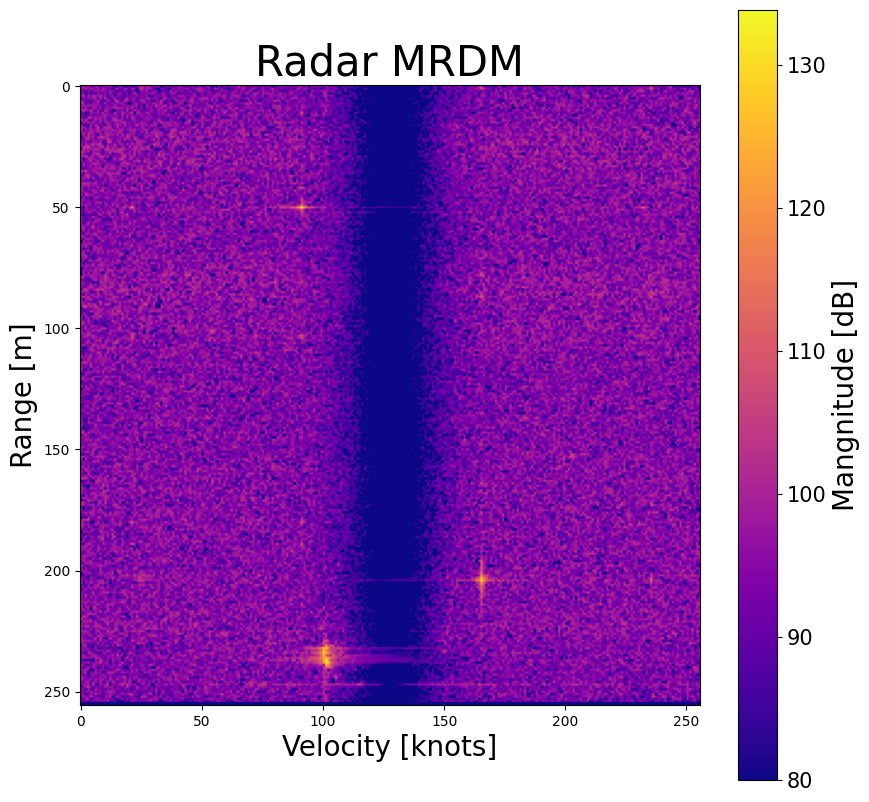

In [46]:
#%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Radar MRDM"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})

#test = np.max(np.abs(data_diff[:500]),axis=0)
test = np.abs(data_diff[249])
plt.figure(figsize=(10,10))
print(np.shape(test))
#test[test>40] =0
rotated_img = ndimage.rotate(test,90)
#rotated_img = np.flip(test,axis=0)
rotated_img =20*np.log10(np.abs(rotated_img)) # We rotate the image so the x axis is the velocity


#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
#plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
plt.imshow(rotated_img,cmap="plasma",vmin=80)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
#plt.xlim(80,94)
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
#plt.savefig("plots/results/radar_MRDM.svg",format="svg")

6454920.701909829
6454920.701909829


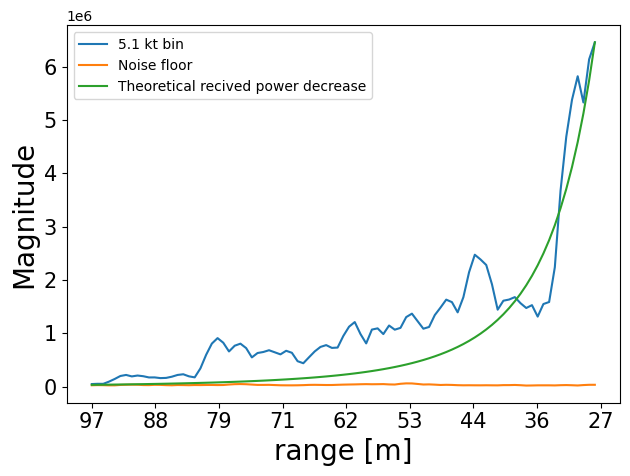

In [29]:
plt.figure()
start_bin =132
end_bin = 221

detections =np.max(np.abs(data_diff),axis=0)
detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,87:93],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="5.1 kt bin")
plt.plot(np.abs(detections[start_bin:end_bin,50]),label="Noise floor")

plt.plot(r_squared,label="Theoretical recived power decrease")

plt.legend()
#plt.title("",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("Magnitude",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
plt.savefig("plots/results/custom_falloff_munkholm.png")
plt.show()

In [67]:
dat_nowindow = data_diff

81.94076685024915
64.30276956928738
117.61311571709264
103.8257455565418


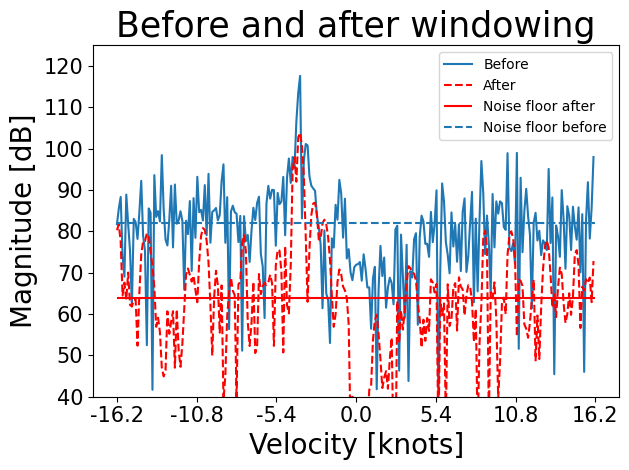

In [71]:
plt.figure()

rotated_diff = ndimage.rotate(dat_nowindow[206], 90)
rotated_raw = ndimage.rotate(data_diff[206], 90)
print(np.mean(20*np.log10(np.abs(rotated_diff[230,:60]))))
print(np.mean(20*np.log10(np.abs(rotated_raw[230,:60]))))
print(np.max(20*np.log10(np.abs(rotated_diff[230,:]))))
print(np.max(20*np.log10(np.abs(rotated_raw[230,:]))))
plt.plot(20*np.log10(np.abs(rotated_diff[230,:])),label="Before")
plt.plot(20*np.log10(np.abs(rotated_raw[230,:])),'--',label="After",color = "red")
plt.hlines(64,0,256,label="Noise floor after",colors=["red"])
plt.hlines(82,0,256,label="Noise floor before",linestyles=["--"])
plt.legend()
plt.title("Before and after windowing",size=25)
plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.ylim(40,125)
plt.xlabel("Velocity [knots]",size=20)
plt.ylabel("Magnitude [dB]",size=20)
plt.tight_layout()
plt.savefig("plots/munkholm/munkholm_befor_and_after_window.svg",format="svg")
plt.show()


# Plot moving average

In [7]:
plot_min_range = 40
plot_max_range = 120
plot_min_doppler = 100
plot_max_doppler = 150
plot_min_3d = 80
plot_max_3d = 95

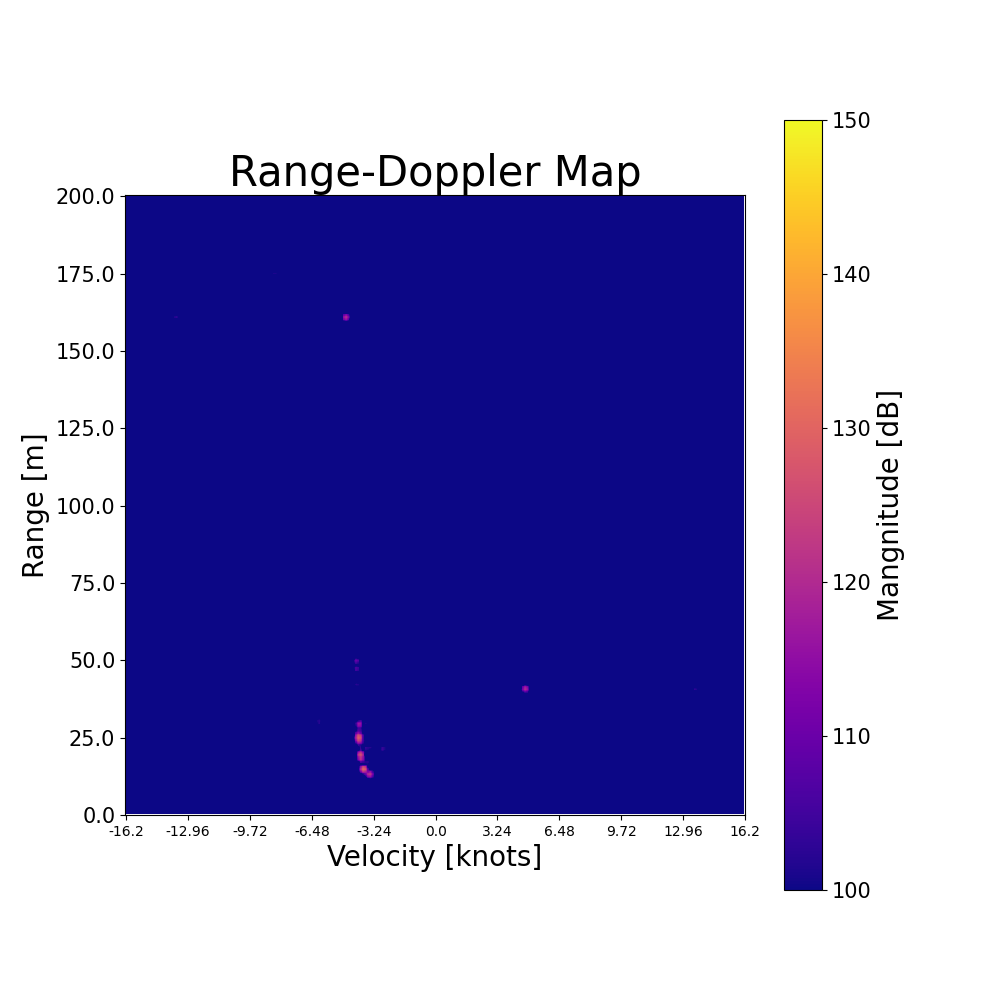

In [ ]:
%matplotlib ipympl
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(10,10))
rotated_img = ndimage.rotate(20*np.log10(np.abs(data_diff[206])),90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)


plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# Plot Fitler frames

In [ ]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)

def animate(i):
    rotated_img = ndimage.rotate(data_diff[i],90)
    ax1.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1.set_title(f"Frame: {i}")
    ax1.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1.autoscale(enable=True, axis='both')

#ani = FuncAnimation(fig, animate,600 ,interval=100,cache_frame_data=False)
#plt.show()

# Calculate and plot CFAR

In [10]:
cfar_array= []
length_data_diff = len(data_diff[:-1])
for i,img in enumerate( data_diff[:-1]):
    cfar ,y,x = utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_array.append(cfar)
    print(np.round(i/length_data_diff*100,1))

NameError: name 'data_diff' is not defined

In [ ]:
cfar_EMA_3 = cfar_array

In [ ]:
cfar_EMA = cfar_array

(256, 256)


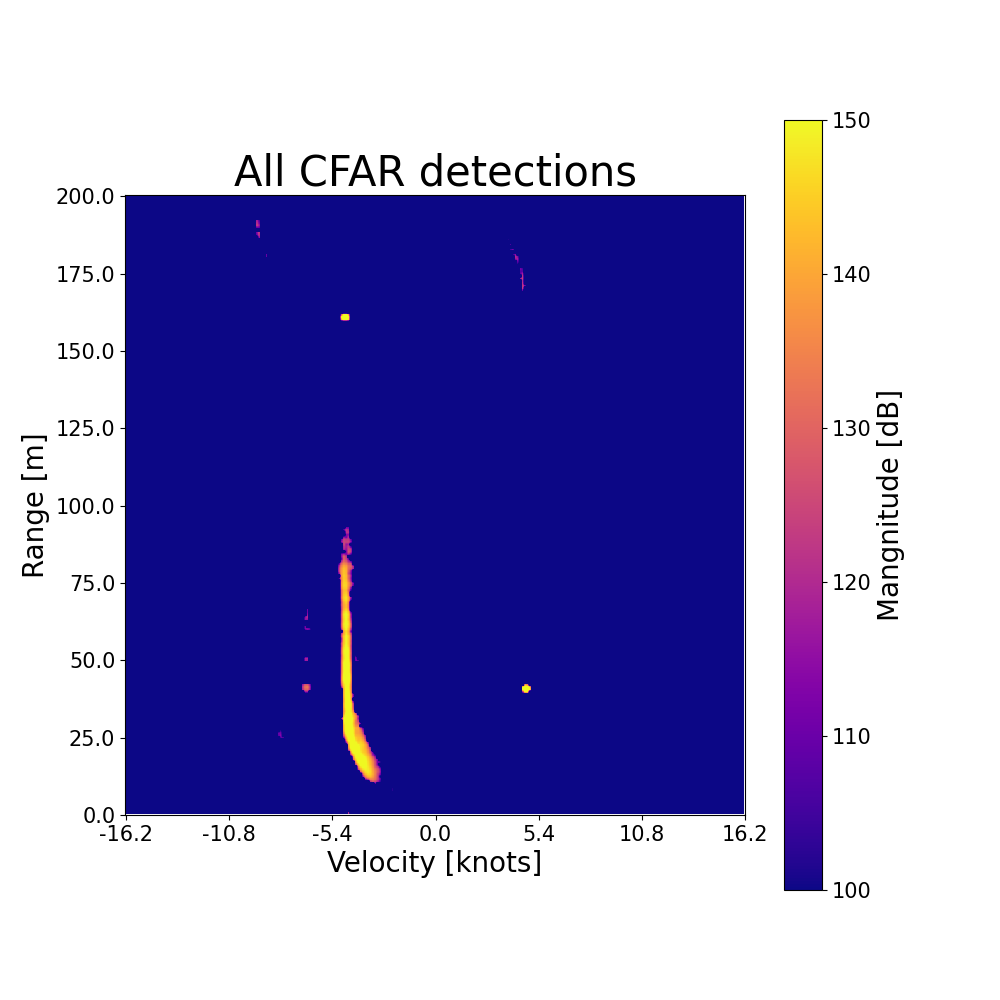

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.sum(np.abs(cfar_array),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=plot_min_doppler,vmax=plot_max_doppler)
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)


plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
plt.savefig("plots/munkholm/cfar_EMA_1_MTI_munkholm_window.svg",format="svg")

# IO

In [ ]:
cfar_IO= []
length_data_diff = len(data_diff[:-1])
for i,img in enumerate( data_diff[:-1]):
    cfar ,y,x = utils.CFAR_IO(img,10, 15, 0.000001,plot=False, iso_axis=True)
    cfar_IO.append(cfar)
    print(np.round(i/length_data_diff*100,1))

traning area 2160


/Users/sondreolimb/prosjektOppgave/ProjectReportCode/utils.py:410: RuntimeWarning: divide by zero encountered in double_scalars
  "SNR":10*np.log10(np.abs(data[i,j])/np.abs(P_training))


0.0
traning area 2160
0.4
traning area 2160
0.7
traning area 2160
1.1
traning area 2160
1.4
traning area 2160
1.8
traning area 2160
2.2
traning area 2160
2.5
traning area 2160
2.9
traning area 2160
3.2
traning area 2160
3.6
traning area 2160
4.0
traning area 2160
4.3
traning area 2160
4.7
traning area 2160
5.1
traning area 2160
5.4
traning area 2160
5.8
traning area 2160
6.1
traning area 2160
6.5
traning area 2160
6.9
traning area 2160
7.2
traning area 2160
7.6
traning area 2160
7.9
traning area 2160
8.3
traning area 2160
8.7
traning area 2160
9.0
traning area 2160
9.4
traning area 2160
9.7
traning area 2160
10.1
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.2
traning area 2160
11.6
traning area 2160
11.9
traning area 2160
12.3
traning area 2160
12.6
traning area 2160
13.0
traning area 2160
13.4
traning area 2160
13.7
traning area 2160
14.1
traning area 2160
14.4
traning area 2160
14.8
traning area 2160
15.2
traning area 2160
15.5
traning area 2160
15.9
traning are

(256, 256)


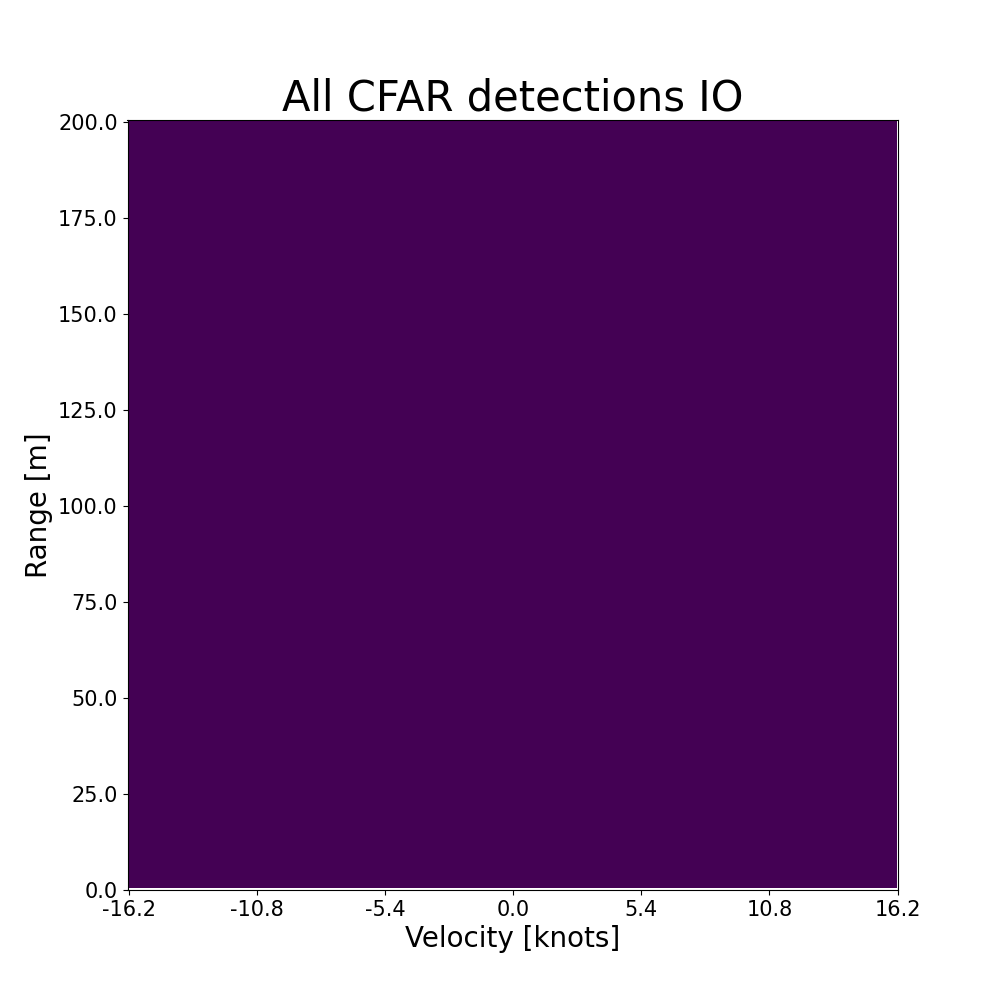

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections IO"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
test = np.sum(np.abs(cfar_IO),axis=0)
test[test>0 ] =1
plt.figure(figsize=(10,10))
print(np.shape(test))

plt.imshow(test )
# rms = 10*np.log(np.sqrt(np.mean(np.abs(rotated_img[130:135,80:100])**2)))
# peak = 10*np.log(np.abs(rotated_img[137,87]))
# snr = peak-rms
# print("Peak:",peak)
# print("Side loab:", 10*np.log(np.abs(rotated_img[137,85])))
# print("RMS:",rms)
# print("SNR:",snr) 
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)



plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)

plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)
plt.savefig("plots/munkholm/cfar_IO_EMA_3_MTI_munkholm_.svg",format="svg")
plt.show()

In [ ]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

fig_cfar=plt.figure()
ax1_cfar=fig_cfar.add_subplot(1,1,1)



def animate_cfar(i):
    rotated_img = ndimage.rotate(cfar_array[i],90)
    ax1_cfar.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000)
    ax1_cfar.set_title(f"Frame: {i}")
    ax1_cfar.set_xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
    ax1_cfar.set_yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    ax1_cfar.autoscale(enable=True, axis='both')

ani_cfar = FuncAnimation(fig_cfar, animate_cfar, interval=100)
plt.show()

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(data_diff[-1], (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(data_diff[-1],90) # We rotate the image so the x axis is the velocity
#rotated_img = cv2.GaussianBlur(rotated_img, (3, 3),sigmaX=1,sigmaY=1)
plt.imshow(rotated_img,cmap="plasma", vmin=0,vmax=300000,)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
#plt.xlim(60,100)
#plt.ylim(130,150)
plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2))
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# Baseline, No MA

In [ ]:
labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "Range-Doppler Map"

}
#data_fft_plot = cv2.GaussianBlur(np.abs(data_ma), (3, 3),sigmaX=1,sigmaY=1)
#data_fft_plot = ndimage.gaussian_filter(data_fft_plot,sigma=1,mode=mode)
#sns.set(rc={'figure.figsize':(20,15)})
plt.figure(figsize=(20,15))
rotated_img = ndimage.rotate(np.abs(raw_t[-1]),90) # We rotate the image so the x axis is the velocity
plt.imshow(rotated_img,cmap="plasma",  vmin=50000,vmax=200000)
rms = np.sqrt(np.mean(rotated_img[139,:])**2)
peak = rotated_img[137,87]
snr = 10*np.log10(peak/rms)
print("Peak:",peak)
print("RMS:",rms)
print("SNR:",snr)
#plt.yticks(np.linspace(0,256,5),labels=np.round(np.linspace(255*0.785277,0,5)),size =15)


#plt.xticks(np.linspace(0,256,11),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,11),2)
#plt.xlim(85,90)
#plt.ylim(135,140)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 
plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
plt.title(labels["title"],fontdict = {'fontsize' : 30})
plt.grid(False)

# calculate all CFAR detections

In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def all_cfar(data_arr, nr_of_ma=0, alpha=1/256, mode="nearest",window=1 ,plot=False,saveFig=False,FileName="CFAR"):
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=alpha,window = window)
    cfar_array= []
    SNR_array = []
    SNR_D_array = []
    length_data_diff = len(data_diff[:-1])
    for i,img in enumerate( data_diff[:-1]):
        cfar ,y,SNR,d= utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
        cfar_array.append(cfar)
        cfar_array.append(cfar)
        SNR_array.append(SNR)
        SNR_D_array.append(y)
        print(np.round(i/length_data_diff*100,1))

    labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
    
    test = np.max(np.abs(cfar_array),axis=0)
    #test[test < 1.1] =0
    #test[test>1] =1
    plt.figure(figsize=(20,20))
    print(np.shape(test))
    rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
    ax = plt.gca()
    cmap = mpl.colors.ListedColormap(['darkBlue','red'])
    bounds=[-0,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(rotated_img,interpolation='nearest',cmap = cmap,norm=norm)
    #plt.imshow(rotated_img,interpolation='nearest',cmap = "plasma",vmin=100,vmax=160)
    plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.1)
    #cbar  = plt.colorbar(cax=cax)
    
    #cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
    #cbar.ax.tick_params(labelsize=15) 
    plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
    plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
    #plt.title(labels["title"],fontdict = {'fontsize' : 30})
    plt.grid(False)
    if saveFig:
        plt.savefig(f"cfar_io/munkholm_{FileName}.svg",format="svg")
    plt.show()
    return cfar_array,SNR_array,SNR_D_array

## Munkholm

### Basleine

MA 0
MA 1
MA 2
0.0
0.4
0.7
1.1
1.4
1.8
2.2
2.5
2.9
3.2
3.6
3.9
4.3
4.7
5.0
5.4
5.7
6.1
6.5
6.8
7.2
7.5
7.9
8.2
8.6
9.0
9.3
9.7
10.0
10.4
10.8
11.1
11.5
11.8
12.2
12.5
12.9
13.3
13.6
14.0
14.3
14.7
15.1
15.4
15.8
16.1
16.5
16.8
17.2
17.6
17.9
18.3
18.6
19.0
19.4
19.7
20.1
20.4
20.8
21.1
21.5
21.9
22.2
22.6
22.9
23.3
23.7
24.0
24.4
24.7
25.1
25.4
25.8
26.2
26.5
26.9
27.2
27.6
28.0
28.3
28.7
29.0
29.4
29.7
30.1
30.5
30.8
31.2
31.5
31.9
32.3
32.6
33.0
33.3
33.7
34.1
34.4
34.8
35.1
35.5
35.8
36.2
36.6
36.9
37.3
37.6
38.0
38.4
38.7
39.1
39.4
39.8
40.1
40.5
40.9
41.2
41.6
41.9
42.3
42.7
43.0
43.4
43.7
44.1
44.4
44.8
45.2
45.5
45.9
46.2
46.6
47.0
47.3
47.7
48.0
48.4
48.7
49.1
49.5
49.8
50.2
50.5
50.9
51.3
51.6
52.0
52.3
52.7
53.0
53.4
53.8
54.1
54.5
54.8
55.2
55.6
55.9
56.3
56.6
57.0
57.3
57.7
58.1
58.4
58.8
59.1
59.5
59.9
60.2
60.6
60.9
61.3
61.6
62.0
62.4
62.7
63.1
63.4
63.8
64.2
64.5
64.9
65.2
65.6
65.9
66.3
66.7
67.0
67.4
67.7
68.1
68.5
68.8
69.2
69.5
69.9
70.3
70.6
71.0
71.3
71.7
72.0
72.

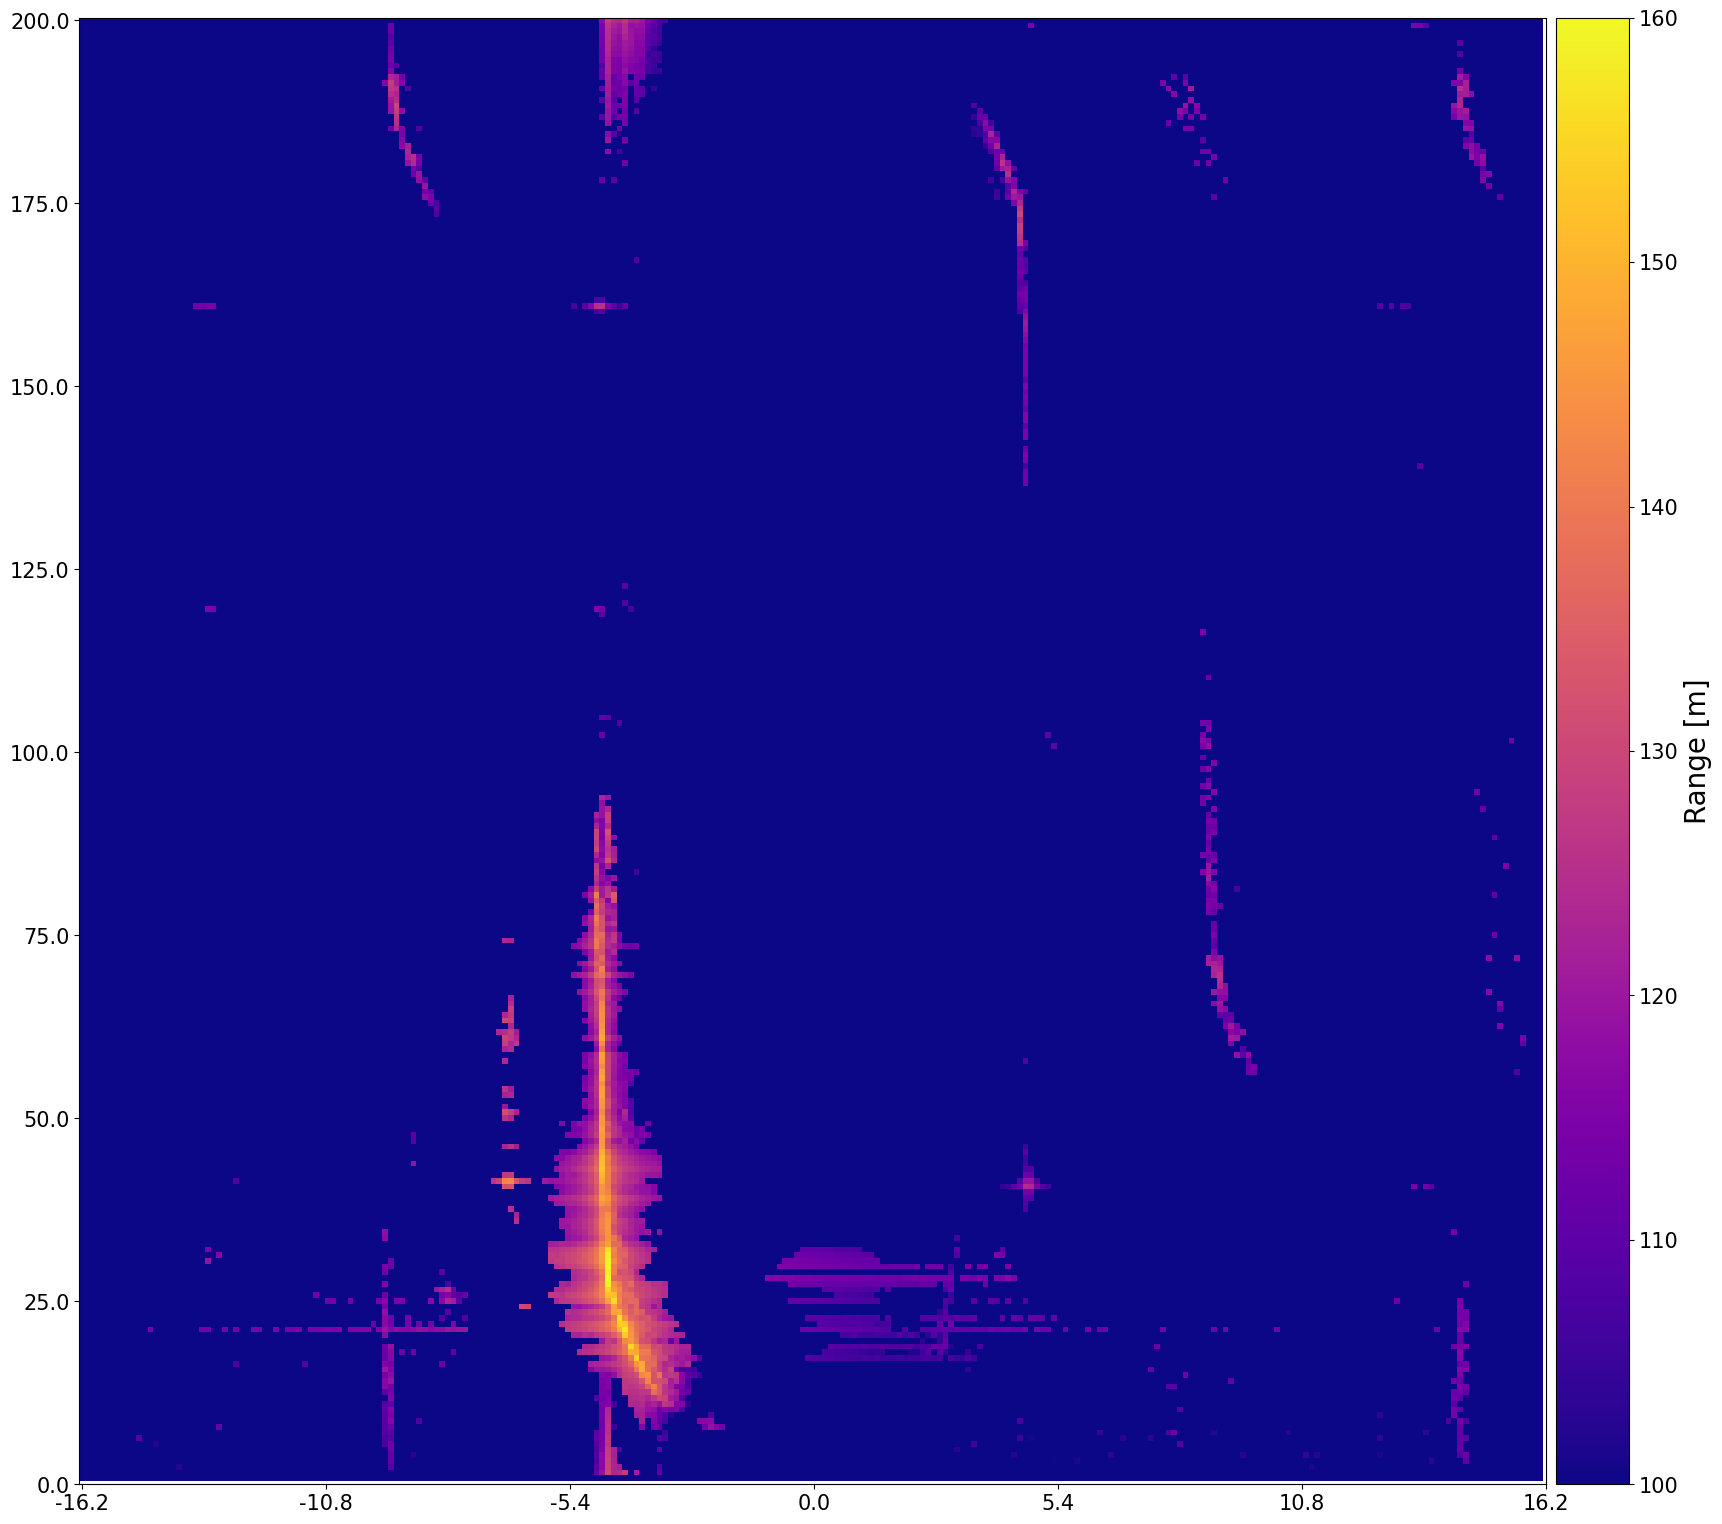

In [42]:
cfar_MA_3,SNR_all_3,SNR_D_3=all_cfar(data_arr, nr_of_ma=3, alpha=1/256, mode="nearest",window = 1 ,plot=False,saveFig=True,FileName="MA_3_results_power_2")

### Chebechew

traning area 2160
traning area 2160
0.0
traning area 2160
0.4
traning area 2160
0.7
traning area 2160
1.1
traning area 2160
1.4
traning area 2160
1.8
traning area 2160
2.2
traning area 2160
2.5
traning area 2160
2.9
traning area 2160
3.2
traning area 2160
3.6
traning area 2160
4.0
traning area 2160
4.3
traning area 2160
4.7
traning area 2160
5.1
traning area 2160
5.4
traning area 2160
5.8
traning area 2160
6.1
traning area 2160
6.5
traning area 2160
6.9
traning area 2160
7.2
traning area 2160
7.6
traning area 2160
7.9
traning area 2160
8.3
traning area 2160
8.7
traning area 2160
9.0
traning area 2160
9.4
traning area 2160
9.7
traning area 2160
10.1
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.2
traning area 2160
11.6
traning area 2160
11.9
traning area 2160
12.3
traning area 2160
12.6
traning area 2160
13.0
traning area 2160
13.4
traning area 2160
13.7
traning area 2160
14.1
traning area 2160
14.4
traning area 2160
14.8
traning area 2160
15.2
traning area 2160
15.

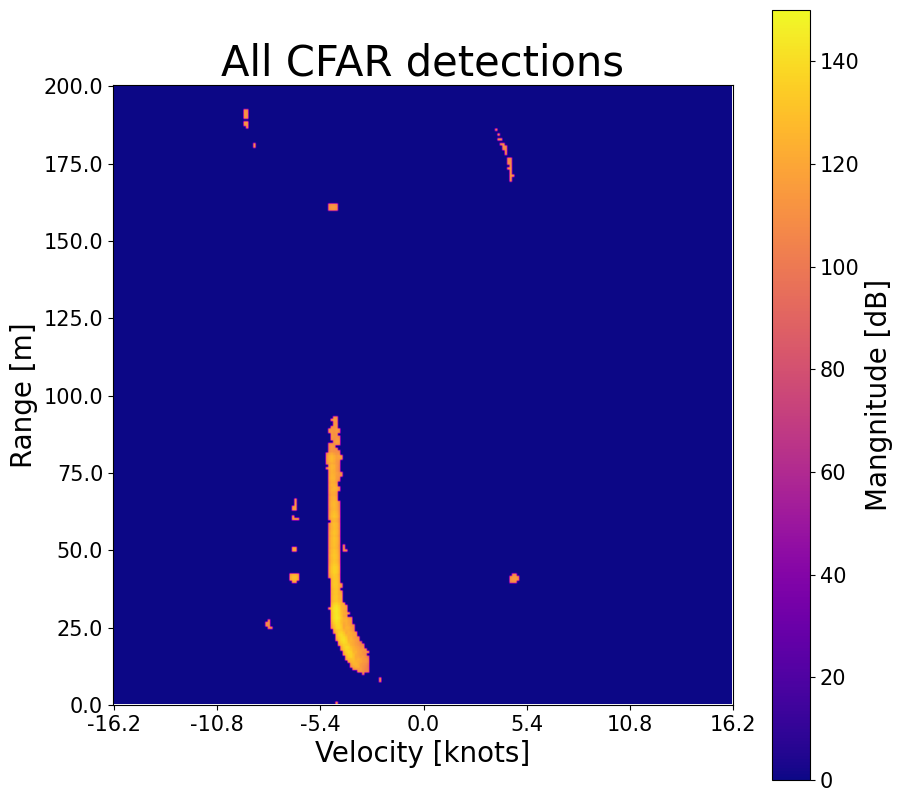

In [20]:

cfar_cheb_100,SNR_all__cheb_100,SNR_D_cheb_100 =all_cfar(data_arr[1:-1], nr_of_ma=0, alpha=1/256, mode="nearest",window = signal.windows.chebwin(256, 100, sym=True) ,plot=False,saveFig=True,FileName="CFAR_munkholm_chebwin_100_results")

MA 0
MA 1
MA 2
0.0
0.4
0.7
1.1
1.4
1.8
2.2
2.5
2.9
3.2
3.6
4.0
4.3
4.7
5.1
5.4
5.8
6.1
6.5
6.9
7.2
7.6
7.9
8.3
8.7
9.0
9.4
9.7
10.1
10.5
10.8
11.2
11.6
11.9
12.3
12.6
13.0
13.4
13.7
14.1
14.4
14.8
15.2
15.5
15.9
16.2
16.6
17.0
17.3
17.7
18.1
18.4
18.8
19.1
19.5
19.9
20.2
20.6
20.9
21.3
21.7
22.0
22.4
22.7
23.1
23.5
23.8
24.2
24.5
24.9
25.3
25.6
26.0
26.4
26.7
27.1
27.4
27.8
28.2
28.5
28.9
29.2
29.6
30.0
30.3
30.7
31.0
31.4
31.8
32.1
32.5
32.9
33.2
33.6
33.9
34.3
34.7
35.0
35.4
35.7
36.1
36.5
36.8
37.2
37.5
37.9
38.3
38.6
39.0
39.4
39.7
40.1
40.4
40.8
41.2
41.5
41.9
42.2
42.6
43.0
43.3
43.7
44.0
44.4
44.8
45.1
45.5
45.8
46.2
46.6
46.9
47.3
47.7
48.0
48.4
48.7
49.1
49.5
49.8
50.2
50.5
50.9
51.3
51.6
52.0
52.3
52.7
53.1
53.4
53.8
54.2
54.5
54.9
55.2
55.6
56.0
56.3
56.7
57.0
57.4
57.8
58.1
58.5
58.8
59.2
59.6
59.9
60.3
60.6
61.0
61.4
61.7
62.1
62.5
62.8
63.2
63.5
63.9
64.3
64.6
65.0
65.3
65.7
66.1
66.4
66.8
67.1
67.5
67.9
68.2
68.6
69.0
69.3
69.7
70.0
70.4
70.8
71.1
71.5
71.8
72.2
72.6
72.

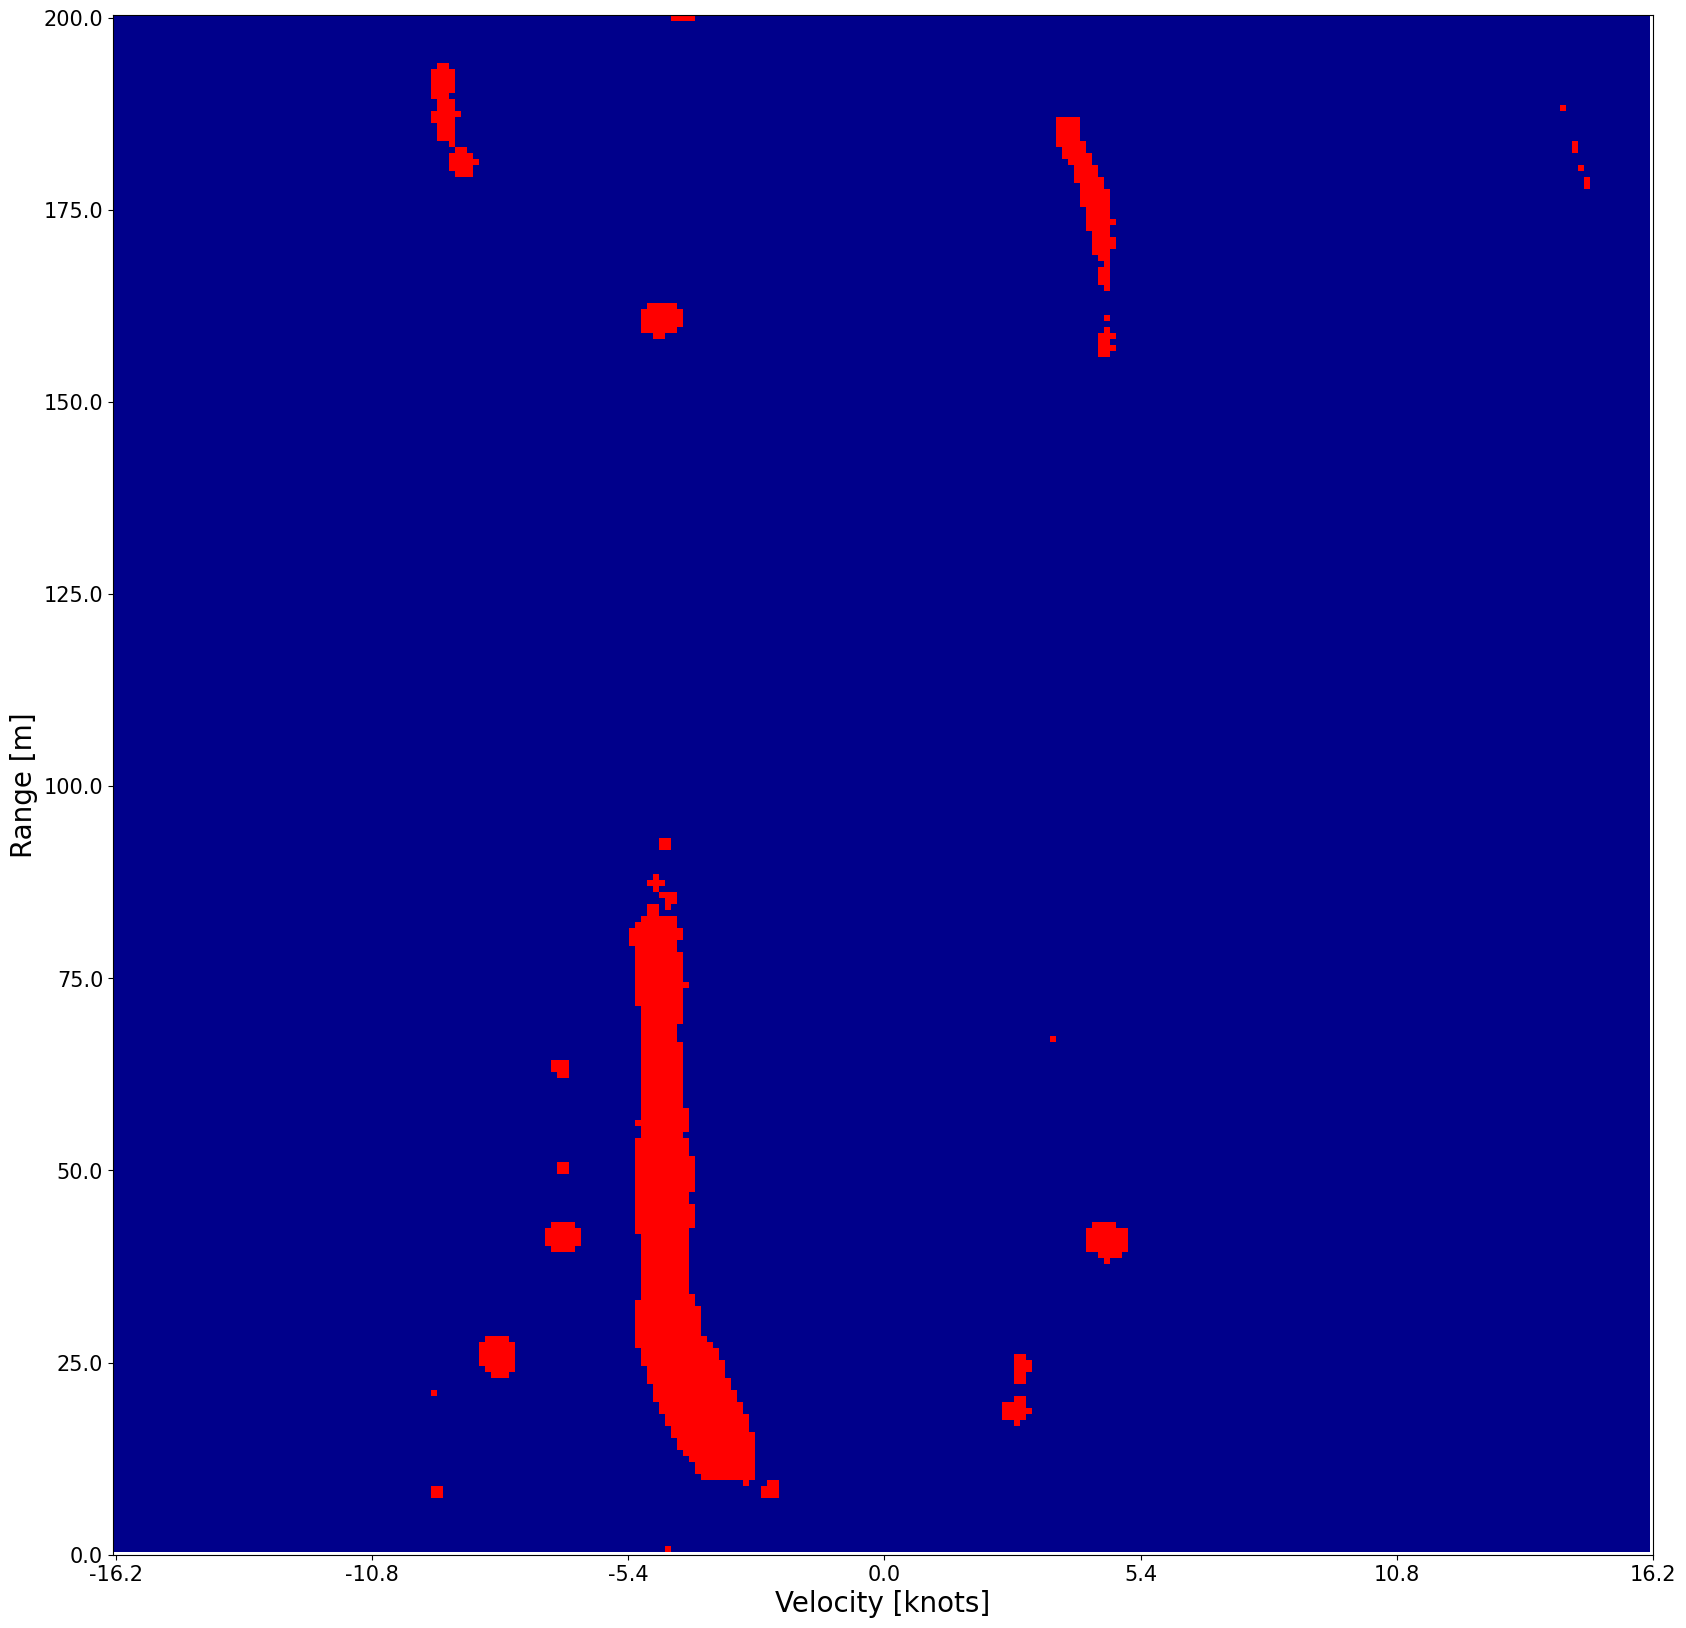

In [46]:
cfar_cheb_200,SNR_all__cheb_200,SNR_D_cheb_200 =all_cfar(data_arr[1:-1], nr_of_ma=3, alpha=1/256, mode="nearest",window = signal.windows.chebwin(256, 300, sym=True) ,plot=False,saveFig=True,FileName="CFAR_munkholm_chebwin_300_ema_io_new")

0.0
0.4
0.7
1.1
1.4
1.8
2.2
2.5
2.9
3.2
3.6
4.0
4.3
4.7
5.1
5.4
5.8
6.1
6.5
6.9
7.2
7.6
7.9
8.3
8.7
9.0
9.4
9.7
10.1
10.5
10.8
11.2
11.6
11.9
12.3
12.6
13.0
13.4
13.7
14.1
14.4
14.8
15.2
15.5
15.9
16.2
16.6
17.0
17.3
17.7
18.1
18.4
18.8
19.1
19.5
19.9
20.2
20.6
20.9
21.3
21.7
22.0
22.4
22.7
23.1
23.5
23.8
24.2
24.5
24.9
25.3
25.6
26.0
26.4
26.7
27.1
27.4
27.8
28.2
28.5
28.9
29.2
29.6
30.0
30.3
30.7
31.0
31.4
31.8
32.1
32.5
32.9
33.2
33.6
33.9
34.3
34.7
35.0
35.4
35.7
36.1
36.5
36.8
37.2
37.5
37.9
38.3
38.6
39.0
39.4
39.7
40.1
40.4
40.8
41.2
41.5
41.9
42.2
42.6
43.0
43.3
43.7
44.0
44.4
44.8
45.1
45.5
45.8
46.2
46.6
46.9
47.3
47.7
48.0
48.4
48.7
49.1
49.5
49.8
50.2
50.5
50.9
51.3
51.6
52.0
52.3
52.7
53.1
53.4
53.8
54.2
54.5
54.9
55.2
55.6
56.0
56.3
56.7
57.0
57.4
57.8
58.1
58.5
58.8
59.2
59.6
59.9
60.3
60.6
61.0
61.4
61.7
62.1
62.5
62.8
63.2
63.5
63.9
64.3
64.6
65.0
65.3
65.7
66.1
66.4
66.8
67.1
67.5
67.9
68.2
68.6
69.0
69.3
69.7
70.0
70.4
70.8
71.1
71.5
71.8
72.2
72.6
72.9
73.3
73.6
74.

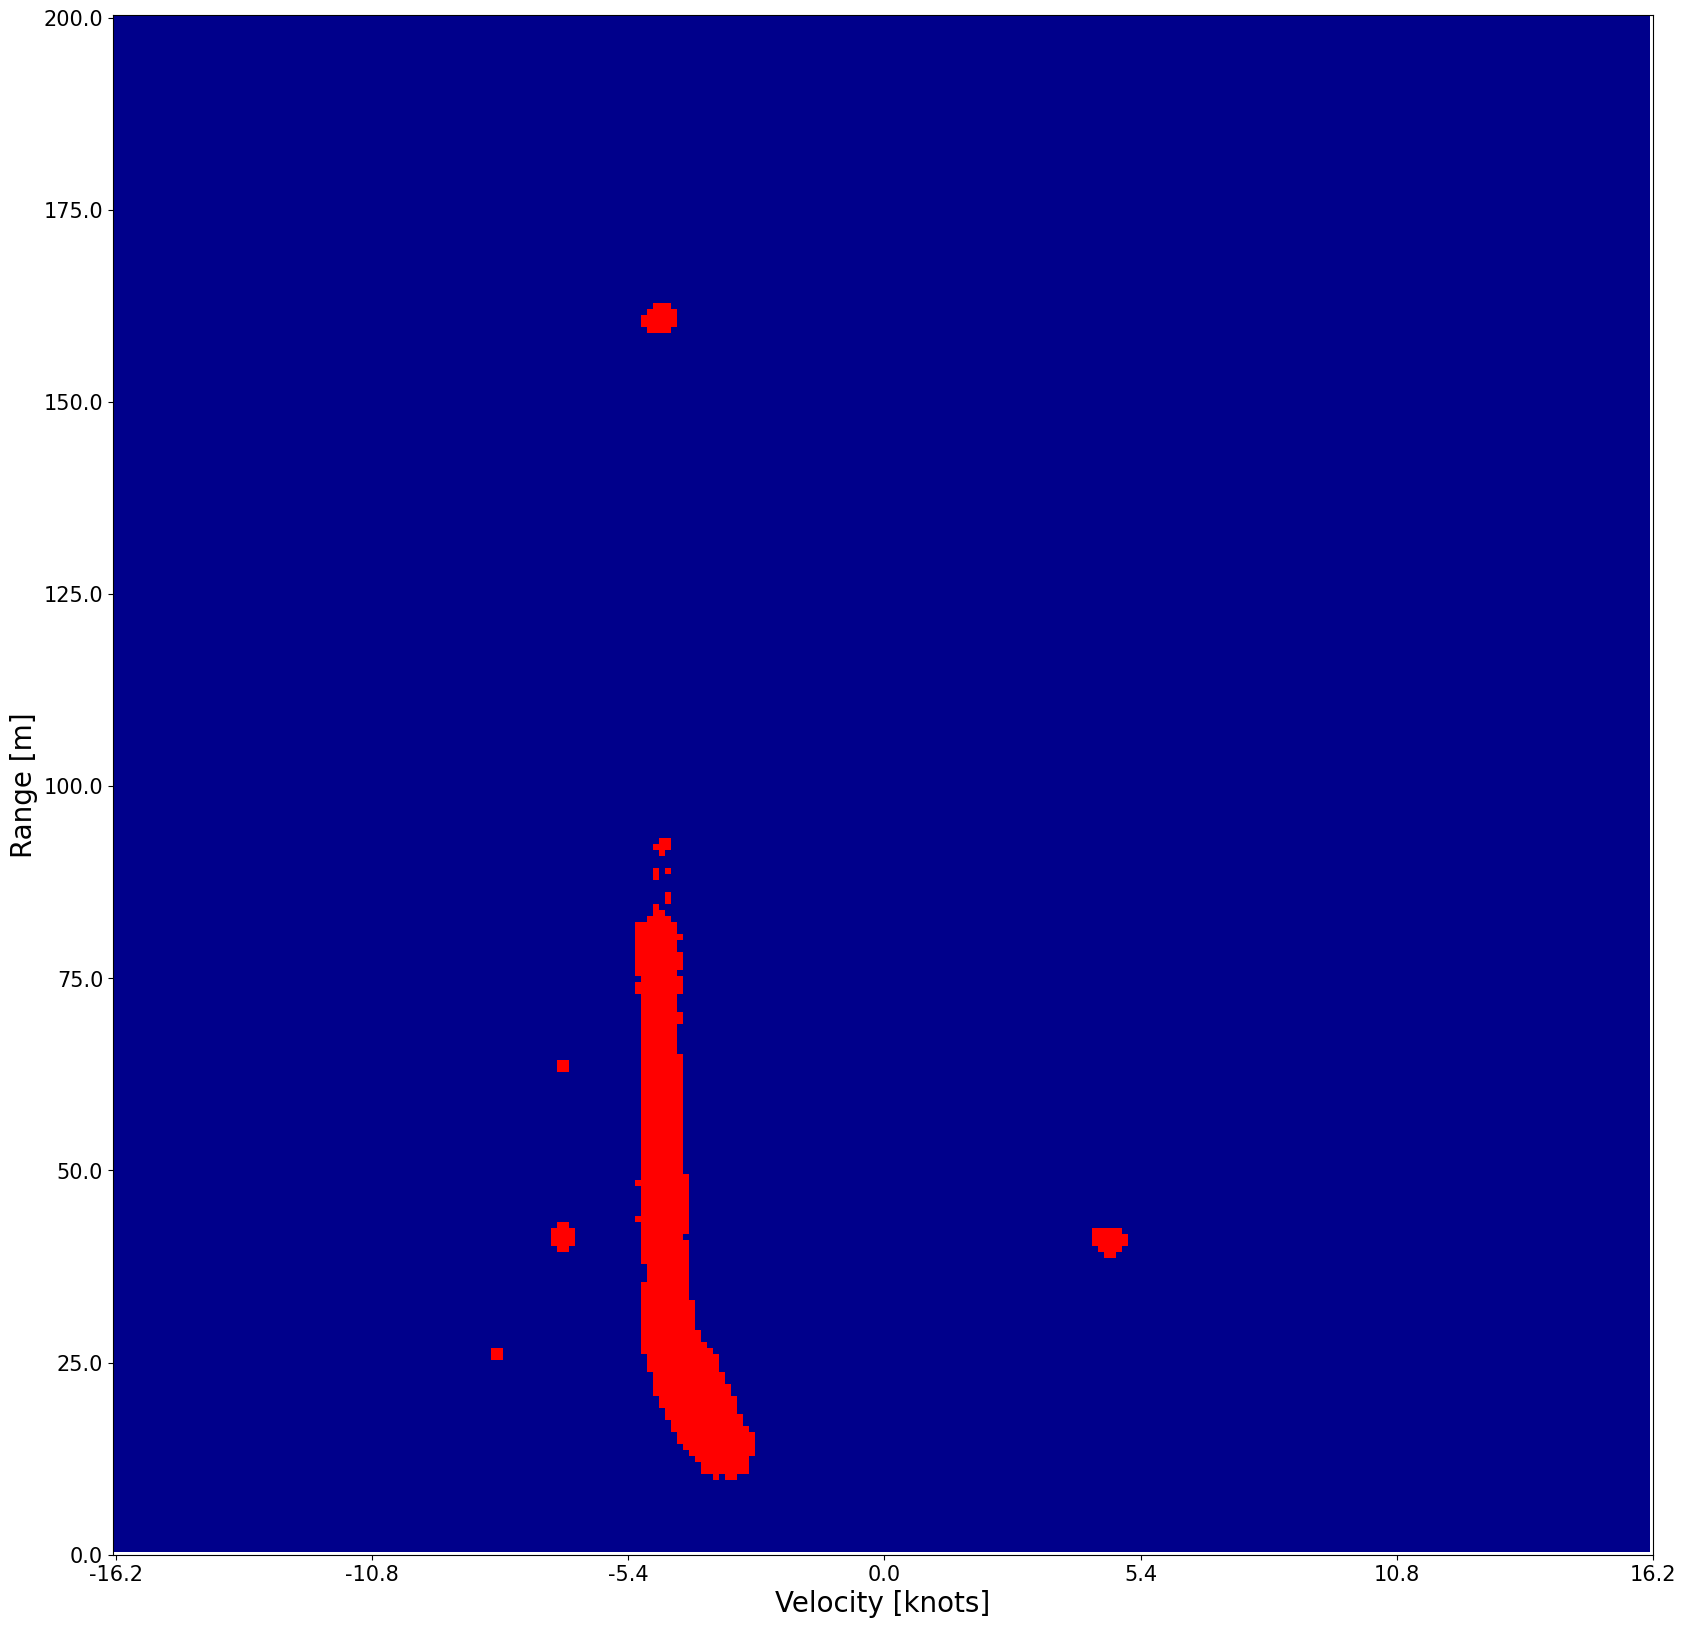

In [48]:
cfar_cheb_300,SNR_all__cheb_300,SNR_D_cheb_300 =all_cfar(data_arr[1:-1], nr_of_ma=0, alpha=1/256, mode="nearest",window = signal.windows.chebwin(256, 300, sym=True) ,plot=False,saveFig=True,FileName="CFAR_munkholm_chebwin_300_results_io_new")

In [47]:
SNR_D_cheb_300

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

nan
nan


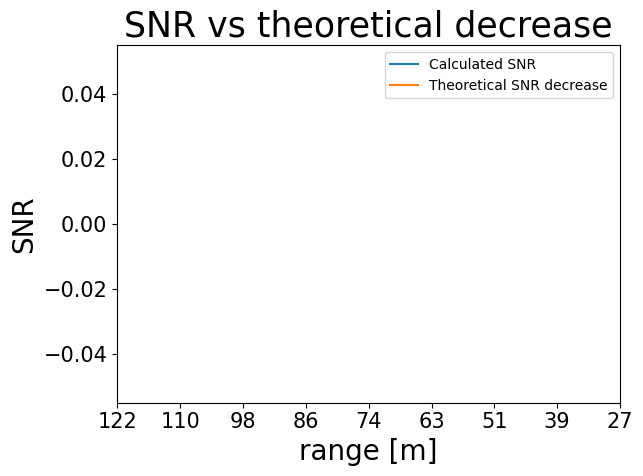

In [13]:
plt.figure()
start_bin =100
end_bin = 221

detections =np.max(np.abs(SNR_D_3),axis=0)
#detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,87:108],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs theoretical decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
#plt.savefig("plots/results/SNR_vs_falloff_custom_munkholm.png")
plt.show()

MA 0
MA 1
MA 2
traning area 2160
traning area 2160
0.0
traning area 2160
0.4
traning area 2160
0.7
traning area 2160
1.1
traning area 2160
1.4
traning area 2160
1.8
traning area 2160
2.2
traning area 2160
2.5
traning area 2160
2.9
traning area 2160
3.2
traning area 2160
3.6
traning area 2160
4.0
traning area 2160
4.3
traning area 2160
4.7
traning area 2160
5.1
traning area 2160
5.4
traning area 2160
5.8
traning area 2160
6.1
traning area 2160
6.5
traning area 2160
6.9
traning area 2160
7.2
traning area 2160
7.6
traning area 2160
7.9
traning area 2160
8.3
traning area 2160
8.7
traning area 2160
9.0
traning area 2160
9.4
traning area 2160
9.7
traning area 2160
10.1
traning area 2160
10.5
traning area 2160
10.8
traning area 2160
11.2
traning area 2160
11.6
traning area 2160
11.9
traning area 2160
12.3
traning area 2160
12.6
traning area 2160
13.0
traning area 2160
13.4
traning area 2160
13.7
traning area 2160
14.1
traning area 2160
14.4
traning area 2160
14.8
traning area 2160
15.2
tranin

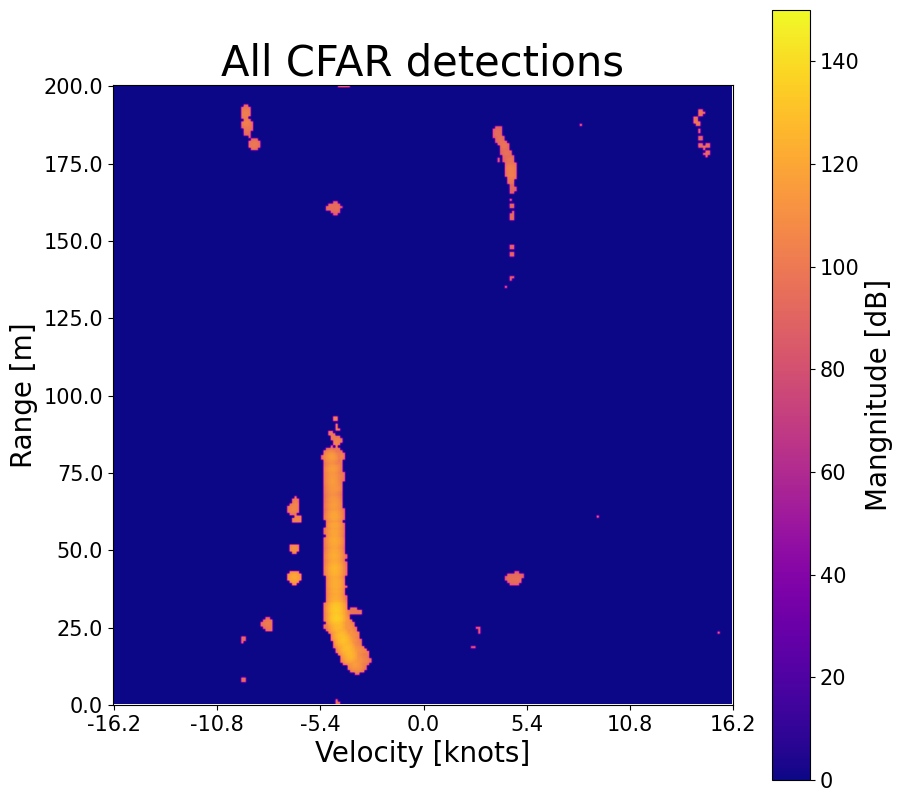

In [23]:
cfar_cheb_300 =all_cfar(data_arr[1:-1], nr_of_ma=3, alpha=1/64, mode="nearest",window = signal.windows.chebwin(256, 300, sym=True) ,plot=False,saveFig=True,FileName="CFAR_munkholm_chebwin_300_ma1")

In [24]:
#cfar_munk_MA_1_chebwin_50 =all_cfar(data_arr[:400], nr_of_ma=1, alpha=1/256, mode="nearest",window = signal.windows.chebwin(256,50,sym=False) ,plot=False,saveFig=True,FileName="CFAR_munk_MA_1_chebwin_50")